In [1]:
from torch.utils.data import DataLoader, Subset
from gym_av_aloha.datasets.av_aloha_dataset import AVAlohaDataset
from gaze_av_aloha.policies.gaze_policy.gaze_model import GazeModel
import torch
from torch import nn, Tensor
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import imageio
import cv2
from IPython.display import Video, display
import einops
import kornia.augmentation as K
import torch.nn.utils as nn_utils
import os
from hydra import initialize_config_dir, compose
from gaze_av_aloha.configs import Config
from torchvision.transforms import Resize, Normalize
import torch.nn.functional as F


In [2]:
input_shape = (240, 320)
resize_shape=(120, 160)
task = "thread_needle"
dataset = f"iantc104/av_aloha_sim_{task}"
model_repo_id = f"iantc104/gaze_model_av_aloha_sim_{task}"
image_keys = [
    "observation.images.zed_cam_left",
]
eye_keys = [
    "left_eye",
]

In [3]:

delta_timestamps = {
    k: [0] for k in image_keys + eye_keys
}
dataset = AVAlohaDataset(
    repo_id=dataset,
    delta_timestamps=delta_timestamps,
)
dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GazeModel(
    resize_shape=resize_shape,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
resize = Resize(input_shape)
normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [5]:
model = model.from_pretrained(model_repo_id).to(device)

In [9]:
def draw_cross(img, center, size=10, color=(0, 0, 255), thickness=2):
    """
    Draws a cross (target-like +) on the image.

    Parameters:
    - img: Input image (numpy array)
    - center: (x, y) coordinates of the cross center
    - size: Length from center to end of each line
    - color: BGR color tuple (default: red)
    - thickness: Line thickness
    """
    x, y = center
    # Vertical line
    cv2.line(img, (x, y - size), (x, y + size), color, thickness)
    # Horizontal line
    cv2.line(img, (x - size, y), (x + size, y), color, thickness)

    return img

ranges = [
    [40, 41]
]
eval_dataset = Subset(dataset, sum([list(range(start, end)) for start, end in ranges], []))
eval_dataloader = DataLoader(eval_dataset, batch_size=64, shuffle=False)
img = None 
heatmap = None
model.eval()
video = []
with torch.no_grad():
    for batch in tqdm(eval_dataloader, desc="Evaluation"):
        images = batch[image_keys[0]].to(device).squeeze(1)
        eye = batch[eye_keys[0]].to(device).squeeze(1)
        images = resize(images)
        pred, heatmaps = model(normalize(images))

        # Visualize a few examples
        for i in range(images.size(0)):
            img = images[i].cpu()
            img = (img * 255).byte().permute(1, 2, 0).numpy()
            heatmap = heatmaps[i].cpu()
            px = ((eye[i][0] + 1) / 2) * img.shape[1]
            py = ((eye[i][1] + 1) / 2) * img.shape[0]
            predx = ((pred[i][0] + 1) / 2) * img.shape[1]
            predy = ((pred[i][1] + 1) / 2) * img.shape[0]

            heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
            heatmap = plt.cm.plasma(heatmap.numpy())  # Apply colormap
            heatmap = (heatmap[:, :, :3] * 255).astype(np.uint8)

            img = cv2.resize(img, (heatmap.shape[1], heatmap.shape[0]), interpolation=cv2.INTER_NEAREST)
            overlay = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)
            # overlay = cv2.circle(overlay, (int(px), int(py)), 3, (0, 255, 0), -1)
            # overlay = cv2.circle(overlay, (int(predx), int(predy)), 3, (255, 0, 0), -1)
            # overlay = draw_cross(overlay, center=(int(predx), int(predy)), size=5, color=(255, 0, 0), thickness=2)

            video.append(overlay)

# Save video
video_path = "mdn_saliency_video.mp4"
imageio.mimwrite(video_path, video, fps=25)

# Display video in Jupyter
display(Video(video_path, embed=True, width=512, height=384))


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 40.83it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 120) to (160, 128) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


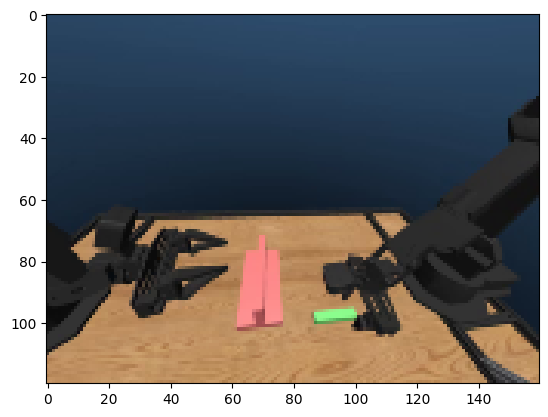

In [ ]:
plt.imsave("heatmap.png", overlay)
plt.imshow()
